In [1]:
import sys
import os
import json
from tqdm.auto import tqdm
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
import math
import collections

sys.path.append("modules")
from projections.cameras import *

In [2]:
DATA_ROOT = Path("data/final_sun360")
IMG_PATH = DATA_ROOT / "rgb_images"
CALIB_PATH = DATA_ROOT / "calibration"

assert IMG_PATH.exists()
assert CALIB_PATH.exists()

In [3]:
def get_description(data_folder_calib, seq_idx_side:str) -> ImageDescription:
    file = f"{seq_idx_side}.json"
    with open(data_folder_calib / file , "r") as f:
        des_dict = json.load(f)

    des = ImageDescription.from_des_dict(des_dict=des_dict)
    return des

In [4]:
def hist_plot(data, ax, x_label:str = "data", stat="count",bins=20, binwidth=None, binrange=None):
    sns.histplot(data, kde=True,
        bins=bins, color = 'darkblue', stat=stat, binwidth=binwidth,
        alpha=.4, edgecolor=(1, 1, 1, .4), ax=ax, binrange=binrange,
        )
    ax.set(xlabel=x_label)

In [5]:
def append_or_init(dictionary, key, val):
    if key not in dictionary:
        dictionary[key] = [val]
    else:
        dictionary[key].append(val)

In [6]:
def group_intrinsics_by_focal(resolutions,focals,xi_list,a_list,resolution_bin_size=100, min_generated_res=500):
    focals_grouped = {}
    xis_grouped = {}
    as_grouped = {}

    for res,f,xi,a in zip(resolutions,focals,xi_list,a_list ):
        if res == min_generated_res:
            res += 1
        res_group = int(math.ceil(res/resolution_bin_size) * resolution_bin_size)

        append_or_init(focals_grouped, res_group, val=f)
        append_or_init(xis_grouped, res_group, val=xi)
        append_or_init(as_grouped, res_group, val=a)

    focals_grouped = collections.OrderedDict(sorted(focals_grouped.items()))
    xis_grouped = collections.OrderedDict(sorted(xis_grouped.items()))
    as_grouped = collections.OrderedDict(sorted(as_grouped.items()))

    return [focals_grouped, xis_grouped, as_grouped], ["focals","xis","as"]

In [7]:
def plot_grouped_intrinsics(intrinsics_grouped, intrinsics_names):
    nrows = len(intrinsics_grouped[0]) # number of resolution groups
    ncols = len(intrinsics_grouped) #number of intrinsics

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 5*nrows))

    for col, (intrinsic_grouped, intrinsic_name) in enumerate(zip(intrinsics_grouped, intrinsics_names)):
        for row, (res_group, vals) in enumerate(intrinsic_grouped.items()):
            hist_plot(vals, x_label=f"{intrinsic_name}_{res_group}", ax=axs[row,col])

    plt.show()

In [8]:
focals = []
resolutions = []
xi_list = []
a_list = []
focals_adj = []
a_fovs = []
va_vecs = []

In [10]:
total_params = os.listdir(IMG_PATH)
min_generated_res = 500
resolution_bin_size = 100
resized_width = 1000

focals_grouped = {}

xis_grouped = {}
as_grouped = {}

for path in tqdm(total_params):       
    fisheye_des = get_description(CALIB_PATH, path.split('.')[0])

    res = fisheye_des.width
    f = fisheye_des.f
    xi = fisheye_des.xi_
    a = fisheye_des.a_

    resolutions.append(res)
    focals.append(f)
    focals_adj.append(f * resized_width / res)
    xi_list.append(xi)
    a_list.append(a)
    va_vecs.append(np.degrees(fisheye_des.get_va_vector())*2)
    a_fovs.append(va_vecs[-1][-1])

    if res == min_generated_res:
        res += 1
    res_group = int(math.ceil(res/resolution_bin_size) * resolution_bin_size)

    append_or_init(focals_grouped, res_group, val=f)
    append_or_init(xis_grouped, res_group, val=xi)
    append_or_init(as_grouped, res_group, val=a)


  0%|          | 0/10360 [00:00<?, ?it/s]

In [11]:
focals_grouped = collections.OrderedDict(sorted(focals_grouped.items()))
xis_grouped = collections.OrderedDict(sorted(xis_grouped.items()))
as_grouped = collections.OrderedDict(sorted(as_grouped.items()))

intrinsics_grouped = [focals_grouped, xis_grouped, as_grouped]
intrinsics_names = ["focals","xis","as"]

In [12]:
iiii = np.argsort(focals)[0]

In [13]:
total_params[np.argmax(a_fovs)]

'17-pano_e52363eb199489dda7c9777ed5169892.png'

In [14]:
focals[iiii]

35.22683666152429

In [15]:
xi_list[iiii]

-0.7948181437751165

In [16]:
total_params[iiii]

'01-pano_anrsqelkceetee.png'

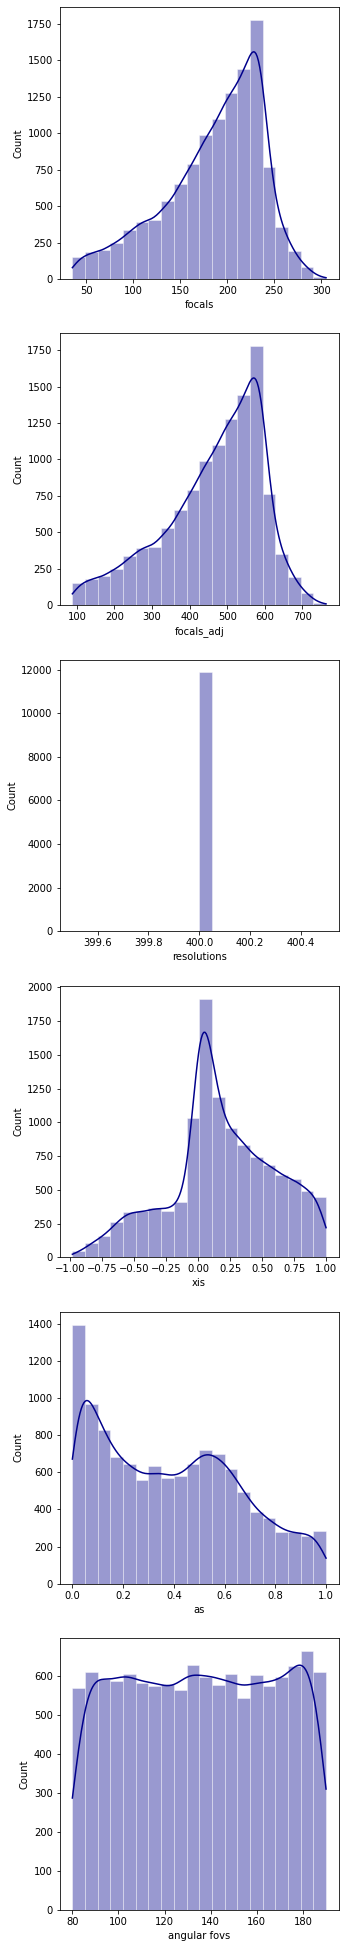

In [17]:
fig, axs = plt.subplots(nrows=6, figsize=(5, 35))
hist_plot(np.array(focals)[np.array(a_fovs)<=190], x_label="focals", ax=axs[0])
hist_plot(np.array(focals_adj)[np.array(a_fovs)<=190], x_label="focals_adj", ax=axs[1])
hist_plot(np.array(resolutions)[np.array(a_fovs)<=190], x_label="resolutions", ax=axs[2])
hist_plot(np.array(xi_list)[np.array(a_fovs)<=190], x_label="xis", ax=axs[3])
hist_plot(np.array(a_list)[np.array(a_fovs)<=190], x_label="as", ax=axs[4])
hist_plot(np.array(a_fovs)[np.array(a_fovs)<=190], x_label="angular fovs", ax=axs[5])
plt.show()


In [18]:
import pandas as pd

In [19]:
print(min(a_fovs))

80.05262585745307


In [20]:
data=pd.DataFrame(va_vecs)

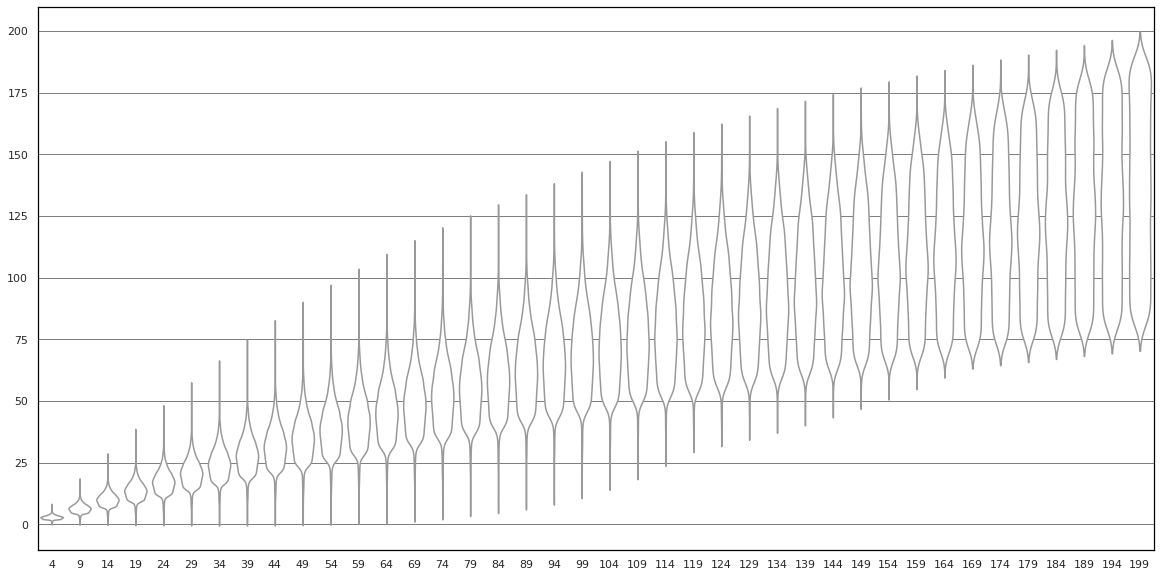

In [21]:
sns.set(rc={'figure.figsize':(20,10)})
fig = plt.figure()
ax = fig.add_subplot(111)
sns.violinplot(data=data.loc[:,4::5], scale='width', inner=None, color='white', ax=ax)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.set_fc('white')
ax.grid(axis = 'y',color='gray')

<AxesSubplot: >

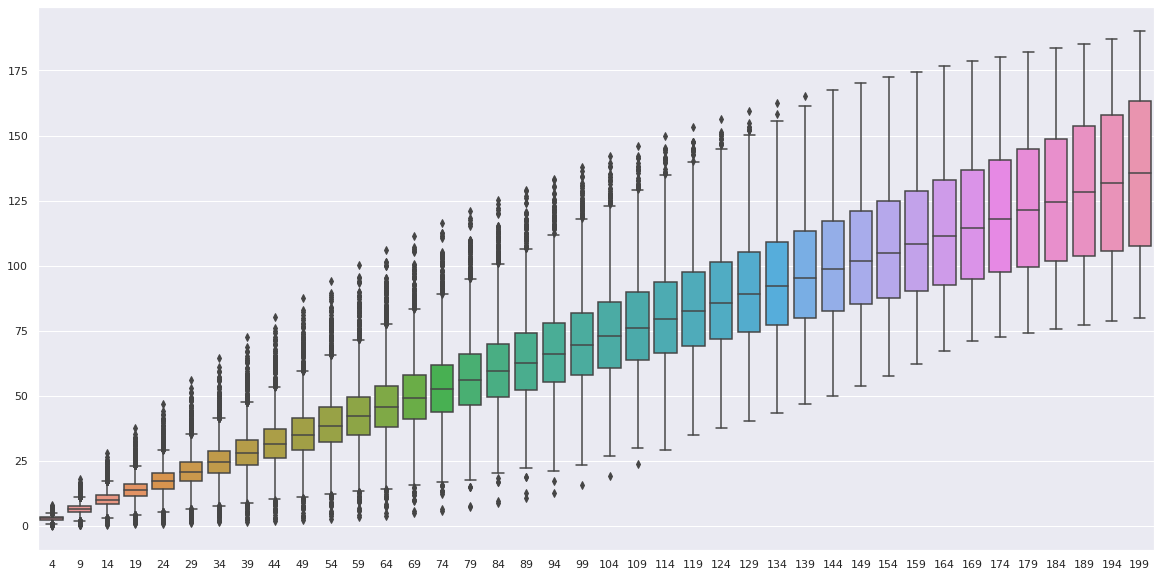

In [22]:
sns.set(rc={'figure.figsize':(20,10)})
#sns.violinplot(data=data.loc[:,4::5], scale='count', inner="quartiles")
sns.boxplot(data=data.loc[:,4::5])

In [23]:
data.index.name = "sample"
data.columns.name = "levels"

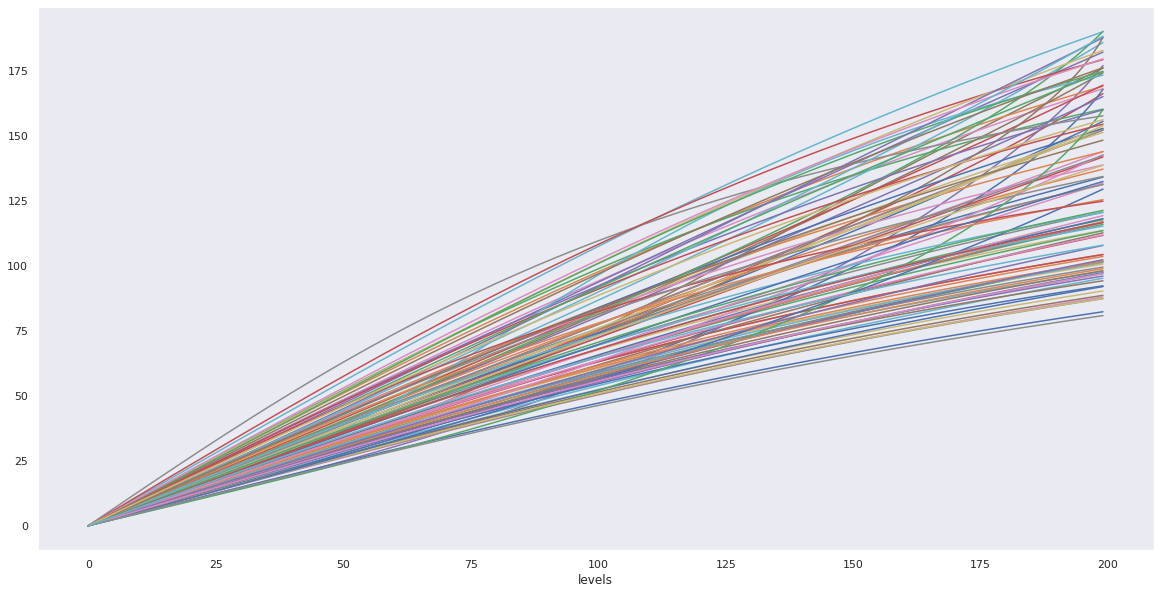

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
data.sample(n=100,random_state=35).T.plot(figsize=(20, 10), legend=False, ax=ax, grid=False)

fig.savefig('temp.png', transparent=True)

<AxesSubplot: xlabel='levels'>

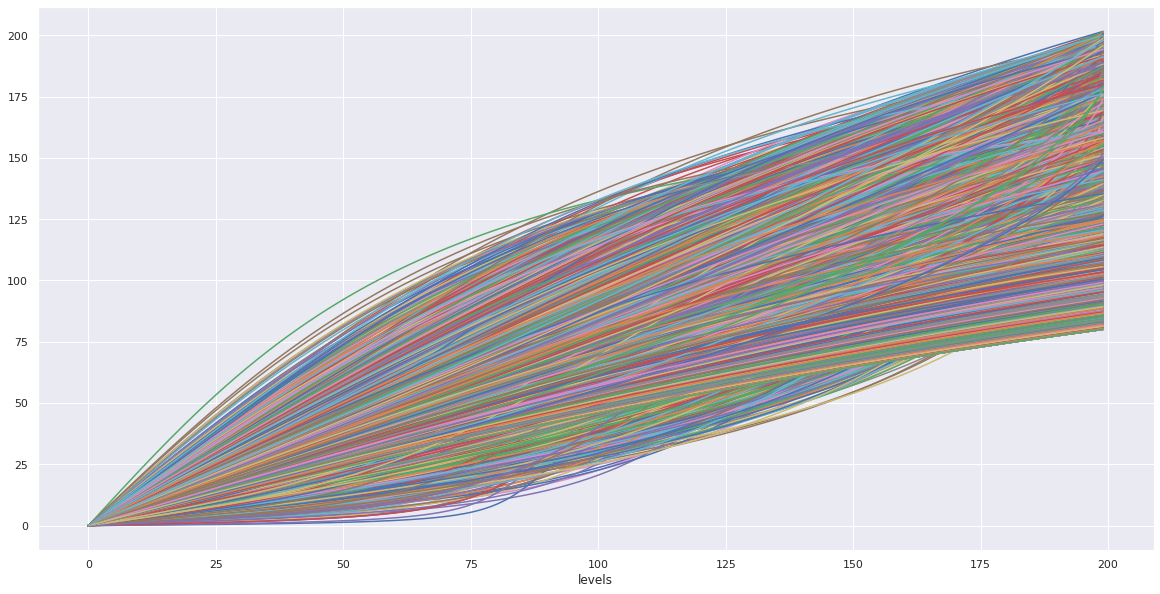

In [ ]:
data.T.plot(figsize=(20, 10), legend=False)

In [92]:
_va_vecs = [np.radians(va_vec/2) for va_vec in va_vecs]

In [26]:
for i in range(1,10):
    print(np.mean(np.abs(_va_vecs[0]-_va_vecs[i])), np.linalg.norm(_va_vecs[0]-_va_vecs[i]))

0.10201242814802387 1.5994290037604142
0.060822433473122536 0.992649266111977
0.041654665600131244 0.6919562710379888
0.12810280621410824 2.006186857534746
0.16283798195992538 2.544062211865985
0.1782903689985531 2.7858663912723567
0.11854652653440578 1.8544814702468995
0.13582213778109703 2.1269709756993955
0.12794658051807917 2.0007659807570963


In [19]:
for i in range(10):
    min_afov = idxs[-i-1]
    print(a_fovs[min_afov], focals[min_afov], a_list[min_afov], xi_list[min_afov])

142.92401938869855 215.92757039246942 0.3200106564760178 0.5803295305534406
142.9065990304827 191.6191955684769 0.5225509182876455 0.3343699674257816
142.6216040394076 241.71363889203056 0.819728044685997 0.46541811079215223
142.61440375375872 291.4578920015853 0.7286336047061123 0.8171307163409436
142.46467562504984 265.4206753190091 0.9744446822245587 0.5301246934235126
142.3140544076371 298.1932260703248 0.698425748343648 0.8639025670786249
142.30984259790495 245.42413740097493 0.6662535425975316 0.5727881417725402
142.02111509099393 216.06822506287108 0.9759143824595312 0.11061166403372913
141.718697710592 83.42335970864713 0.555170199931246 -0.7089191548711116
141.46855888330217 187.1892154611697 0.8872029173433033 -0.09991955557454935


In [20]:
a_fovs[0]

141.718697710592

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

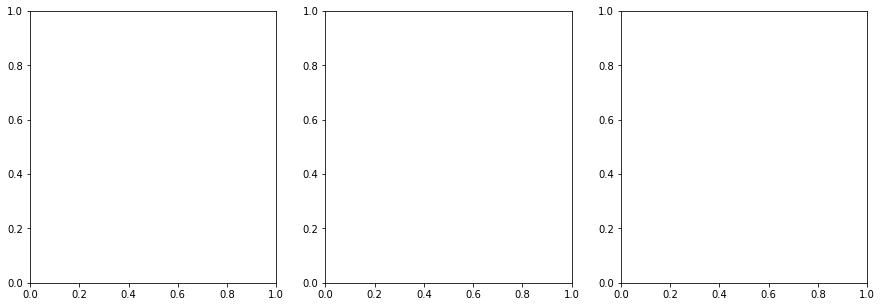

In [12]:
plot_grouped_intrinsics(intrinsics_grouped, intrinsics_names)

In [15]:
len(focals_adj)

6926

In [16]:
def filter_barrel_distortion(xi_list, a_list):
    idxs = []
    for i, (xi, a) in enumerate(zip(xi_list, a_list)):
        if xi< 0 and a < 0.4: # In this case it is a pincushion distortion
            continue
        idxs.append(i)
    return idxs

In [17]:
barrel_distortion_dixs = filter_barrel_distortion(xi_list, a_list)
print(len(barrel_distortion_dixs))

6926


In [18]:
def filter_list(p_lsit, idxs):
    n_list = np.array(p_lsit)
    f_list = n_list[idxs]
    return f_list.tolist()

In [52]:
b_focal_adj = filter_list(focals_adj, barrel_distortion_dixs)
b_xi_list = filter_list(xi_list, barrel_distortion_dixs)
b_a_list = filter_list(a_list, barrel_distortion_dixs)

In [53]:
group_size = 100
bin_start = 5

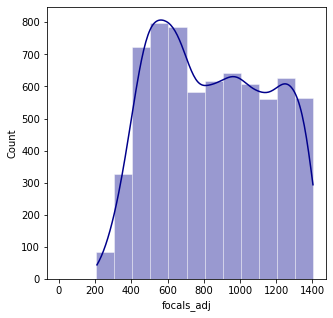

In [54]:
fig, axs = plt.subplots(nrows=1, figsize=(5, 5))
hist_plot(focals_adj, x_label="focals_adj",stat='count', ax=axs, binwidth=group_size, binrange=(bin_start,max(focals_adj)))
plt.show()

In [55]:
max_count_for_group = 300

In [56]:
def subsampling_focal_based(focals, max_count_for_group, group_size, group_start=0):
    groups = {}
    for i,focal in enumerate(focals):
        group_idx = (focal - group_start) // group_size
        if group_idx not in groups:
            groups[group_idx] = []
        groups[group_idx].append(i)
    
    sampled_idxs = []
    for group in groups.values():
        if len(group) <= max_count_for_group:
            sampled_idxs.append(np.array(group))
            continue
        samples = np.random.default_rng().choice(group,replace=False, size=(max_count_for_group))
        sampled_idxs.append(samples)

    c_idxs = np.concatenate(sampled_idxs)
    return c_idxs

In [57]:
sampled_idxs = subsampling_focal_based(b_focal_adj, max_count_for_group, group_size, group_start=bin_start)
sampled_idxs.shape

(3384,)

In [58]:
f_focal_adj = filter_list(b_focal_adj, sampled_idxs)
f_xi_list = filter_list(b_xi_list, sampled_idxs)
f_a_list = filter_list(b_a_list, sampled_idxs)

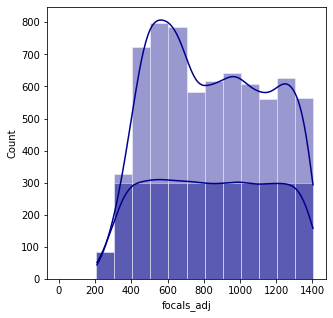

In [59]:
fig, axs = plt.subplots(nrows=1, figsize=(5, 5))
hist_plot(focals_adj, x_label="focals_adj",stat='count', ax=axs, binwidth=group_size, binrange=(bin_start,max(focals_adj)))
hist_plot(f_focal_adj, x_label="focals_adj",stat='count', ax=axs, binwidth=group_size, binrange=(bin_start,max(focals_adj)))
plt.show()

In [60]:
def multi_hist_plot(data_list, x_labels:List[str], stat="density", binwidth=None, binrange=None):
    num = len(data_list)
    fig, axs = plt.subplots(nrows=num, figsize=(5, num*5))
    for i,data in enumerate(data_list):
        hist_plot(data, ax=axs[i], x_label=x_labels[i], stat=stat, binwidth=binwidth, binrange=binrange)
    plt.show()


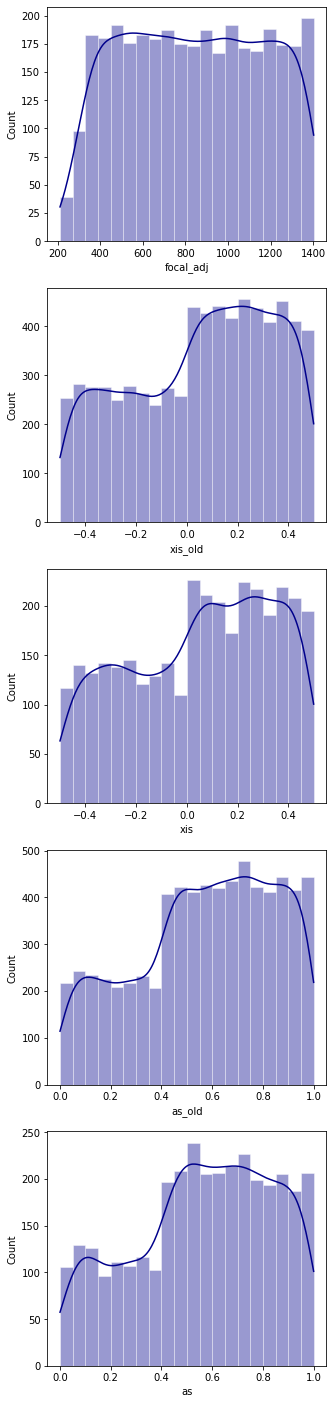

In [61]:
multi_hist_plot(
    [f_focal_adj, xi_list,f_xi_list, a_list,f_a_list],
    ["focal_adj","xis_old","xis","as_old","as"],
    stat='count')

In [62]:
def subsampling_global(n_samples:int, perc:float=None, n_taken:int= None):
    assert perc is not None or n_taken is not None

    if perc is not None:
        n_taken = int(n_samples * perc)

    idxs = np.arange(0,n_samples,1,dtype=int)
    sampled_idxs = np.random.default_rng().choice(idxs, size=(n_taken), replace=False)
    return sampled_idxs
    

In [64]:
print(len(f_focal_adj))
global_idxs = subsampling_global(len(f_focal_adj), perc = .33)
global_idxs.shape

3384


(1116,)

In [65]:
f_focal_adj = filter_list(b_focal_adj, sampled_idxs)
f_xi_list = filter_list(b_xi_list, sampled_idxs)
f_a_list = filter_list(b_a_list, sampled_idxs)

f_focal_adj = filter_list(f_focal_adj, global_idxs)
f_xi_list = filter_list(f_xi_list, global_idxs)
f_a_list = filter_list(f_a_list, global_idxs)

In [66]:
print(len(f_focal_adj),len(f_xi_list),len(f_a_list))

1116 1116 1116


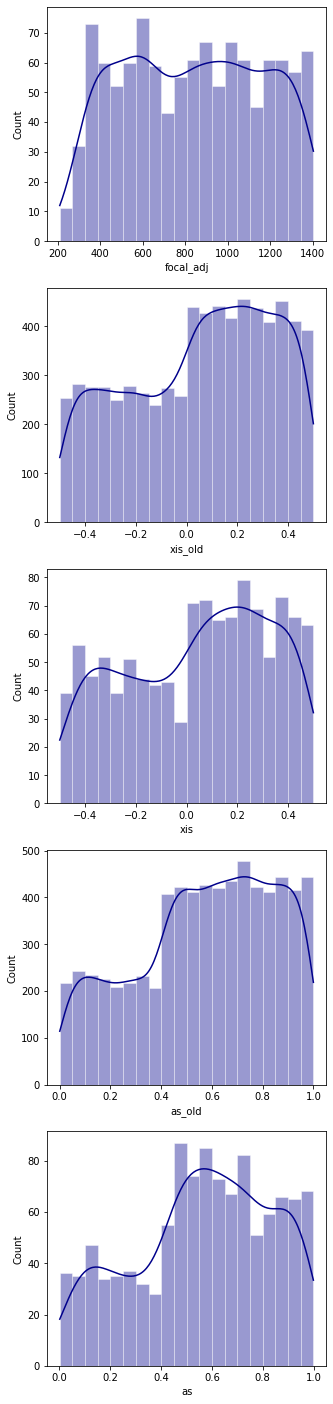

In [67]:
multi_hist_plot(
    [f_focal_adj, xi_list,f_xi_list, a_list,f_a_list],
    ["focal_adj","xis_old","xis","as_old","as"],
    stat='count')

In [68]:
print(len(total_params))
f_paths = filter_list(filter_list(total_params, sampled_idxs), global_idxs)
len(f_paths)

6926


1116

In [69]:
sampled_subset_path = DATA_ROOT / "subset_uniform.txt"

with open(sampled_subset_path, "w") as file:
    file.write("\n".join(f_paths))